In [1]:
import torch
import torch.nn as nn

In [2]:
conv2d_layer = nn.Conv2d(3, 16, kernel_size=3)
conv2d_layer

Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))

In [3]:
# import torchvision
# transform_pipeline = torchvision.transforms.Compose([
#     torchvision.transforms.ToTensor(),
#     torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
#     ])

In [4]:
from torchvision import datasets
cifar10 = datasets.CIFAR10(root='./misc_data', train=True, download=True)
cifar10_val = datasets.CIFAR10(root='./misc_data', train=False, download=True)


Files already downloaded and verified
Files already downloaded and verified


In [5]:
from torchvision import transforms
to_tensor = transforms.ToTensor()
cifar10 = torch.stack([to_tensor(img) for img, _ in cifar10], dim=0)


In [6]:
cifar10.shape

torch.Size([50000, 3, 32, 32])

In [7]:
cifar101 = cifar10.permute(1,2,3,0)

In [8]:
cifar101.shape

torch.Size([3, 32, 32, 50000])

In [9]:
cifar101.contiguous().view(3, -1).shape

torch.Size([3, 51200000])

In [10]:
means = cifar101.contiguous().view(3, -1).mean(1)
std = cifar101.contiguous().view(3, -1).std(1)
means, std

(tensor([0.4914, 0.4822, 0.4465]), tensor([0.2470, 0.2435, 0.2616]))

In [11]:
norm_trans = transforms.Normalize(means, std)

In [12]:
trans = transforms.Compose([to_tensor, norm_trans])

In [13]:
cifar10 = datasets.CIFAR10(root='./misc_data', train=True, download=True,transform=trans)
cifar10_val = datasets.CIFAR10(root='./misc_data', train=False, download=True, transform=trans)
label_map = {0: 0, 2: 1}
label_classes = ['airplane', 'bird']
cifar2 = [(img, label_map[label]) for img, label in cifar10 if label in [0,2]]
cifar2_val = [(img, label_map[label]) for img, label in cifar10_val if label in [0,2]]

Files already downloaded and verified
Files already downloaded and verified


In [14]:
test_output = conv2d_layer(cifar2[0][0].unsqueeze(0))
test_output.shape

torch.Size([1, 16, 30, 30])

In [15]:
cifar2[0][0].unsqueeze(0).shape

torch.Size([1, 3, 32, 32])

In [16]:
z = nn.Conv2d(3,1,3)(cifar2[0][0].unsqueeze(0))
z.shape

torch.Size([1, 1, 30, 30])

In [17]:
nn.MaxPool2d(2)(z).shape

torch.Size([1, 1, 15, 15])

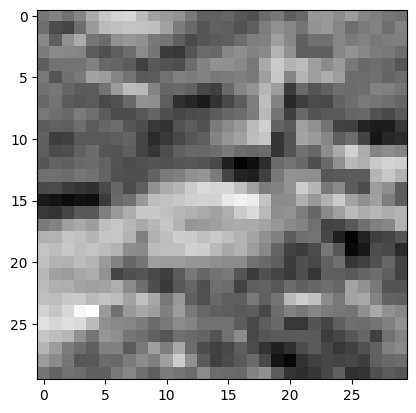

In [18]:
import matplotlib.pyplot as plt
plt.imshow(test_output[0,0].unsqueeze(2).detach(), cmap='gray')

In [19]:
with torch.no_grad():
    conv2d_layer.bias.zero_()
    conv2d_layer.weight.fill_(1.0 / 9.0)

In [20]:
cifar2[0][0].shape

torch.Size([3, 32, 32])

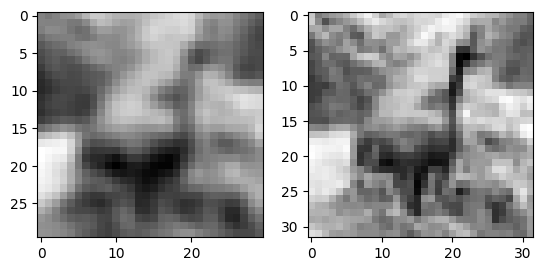

In [21]:
out = conv2d_layer(cifar2[0][0].unsqueeze(0))
fig, axs = plt.subplots(1, 2)
axs[0].imshow(out[0, 0].detach(), cmap='gray')
axs[1].imshow(cifar2[0][0][0].unsqueeze(2), cmap='gray')


In [56]:
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    def __init__(self, n):
        super().__init__()
        self.conv1 = nn.Conv2d(n, n, kernel_size=3, padding=1)
        self.bacthnorm2d_1 = nn.BatchNorm2d(n)
        self.conv2 = nn.Conv2d(n, n, kernel_size=3, padding=1)
        self.bacthnorm2d_2  = nn.BatchNorm2d(n)
        torch.nn.init.kaiming_normal_(self.conv1.weight, nonlinearity='relu')
        torch.nn.init.constant_(self.bacthnorm2d_1.weight, 0.5)
        torch.nn.init.zeros_(self.bacthnorm2d_1.bias)
        
    def forward(self, x):
        out = self.bacthnorm2d_1(self.conv1(x))
        out = F.relu(out)
        out = self.bacthnorm2d_2(self.conv2(out))
        return F.relu(out + x)

class GNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.batchnorm2d_1 = nn.BatchNorm2d(32)
        # self.tanh1 = nn.Tanh()
        # self.maxpool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(32, 15, 3, padding=1)
        self.batchnorm2d_2 = nn.BatchNorm2d(15)
        # self.tanh2 = nn.Tanh()
        # self.maxpool2 = nn.MaxPool2d(2)
        self.resblocks = nn.Sequential(*(50 * [ResidualBlock(15)]))
        self.conv3 = nn.Conv2d(15, 10, 3, padding=1)
        self.lin1 = nn.Linear(10*4*4, 60)
        # self.tanh3 = nn.Tanh()
        self.lin2 = nn.Linear(60, 2)
        
    def forward(self, x):
        out = self.batchnorm2d_1(self.conv1(x))
        out = F.max_pool2d(torch.tanh(out), 2)
        # out = F.dropout2d(out, p=0.1)
        out = self.batchnorm2d_2(self.conv2(out))
        out = F.max_pool2d(torch.tanh(out), 2)
        out = F.dropout2d(out, p=0.2)
        out = F.max_pool2d(torch.tanh(self.conv3(out)), 2)
        out = out.view(-1, 10*4*4)
        out = torch.tanh(self.lin1(out))
        # out = F.dropout(out, p=0.1)
        out = self.lin2(out)
        return out

In [57]:
gnet = GNet()
gnet

GNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm2d_1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 15, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm2d_2): BatchNorm2d(15, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (resblocks): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(15, 15, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bacthnorm2d_1): BatchNorm2d(15, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(15, 15, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bacthnorm2d_2): BatchNorm2d(15, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ResidualBlock(
      (conv1): Conv2d(15, 15, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bacthnorm2d_1): BatchNorm2d(15, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (con

In [58]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
gnet = gnet.to(device)

In [59]:
cifar2_gpu = [(img.to(device), torch.tensor(label).to(device)) for img, label in cifar2]
cifar2_val_gpu = [(img.to(device), torch.tensor(label).to(device)) for img, label in cifar2_val]

In [60]:
from torch.utils.data import DataLoader

val_loader = DataLoader(cifar2_val_gpu, batch_size=64, shuffle=False)
train_loader = DataLoader(cifar2_gpu, batch_size=64, shuffle=True)


In [68]:
import datetime
gnet = GNet().to(device)
n_epochs = 90
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(gnet.parameters(), lr=0.01, 
                            weight_decay=0.005, momentum=0.9)
gnet.train()
for epoch in range(1, 1 + n_epochs):
    loss_total = 0
    for imgs, labels in train_loader:
        outputs = gnet(imgs)
        loss = loss_fn(outputs, labels)
        # l2_lambda = 0.001
        # l2_norm = sum(p.pow(2.0).sum() for p in gnet.parameters())
        # loss += l2_lambda * l2_norm
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_total += loss.item()
    if (epoch % 10 == 0 or epoch == 1):
        print(f"{datetime.datetime.now()} -- Epoch: {epoch}, Loss/batch: {loss_total/len(train_loader)}")

2024-03-16 03:28:08.392352 -- Epoch: 1, Loss/batch: 0.4690724715685389
2024-03-16 03:28:16.141799 -- Epoch: 10, Loss/batch: 0.28843584400453387
2024-03-16 03:28:24.666278 -- Epoch: 20, Loss/batch: 0.24157491316840907
2024-03-16 03:28:33.125925 -- Epoch: 30, Loss/batch: 0.23042928356273917
2024-03-16 03:28:41.603413 -- Epoch: 40, Loss/batch: 0.21820198825210524
2024-03-16 03:28:50.078440 -- Epoch: 50, Loss/batch: 0.21424253318150333
2024-03-16 03:28:58.551871 -- Epoch: 60, Loss/batch: 0.2064610776627899
2024-03-16 03:29:07.030812 -- Epoch: 70, Loss/batch: 0.19368545174788518
2024-03-16 03:29:15.517899 -- Epoch: 80, Loss/batch: 0.20163624107268205
2024-03-16 03:29:24.028117 -- Epoch: 90, Loss/batch: 0.19430569673229933


In [69]:
def calculate_accuracy(loader):
    correct = 0
    total = 0
    gnet.eval()
    with torch.no_grad():
        for data in loader:
            inputs, labels = data
            # inputs = inputs.to(device)
            # labels = labels.to(device)

            outputs = gnet(inputs)
            # print(F.softmax(outputs[10].unsqueeze(0), dim=1))
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy

train_accuracy = calculate_accuracy(train_loader)
val_accuracy = calculate_accuracy(val_loader)

print(f"Train Accuracy: {train_accuracy}%")
print(f"Validation Accuracy: {val_accuracy}%")


Train Accuracy: 91.05%
Validation Accuracy: 87.7%


In [70]:
# torch.save(gnet.state_dict(), 'gnet.pth')

In [71]:
list(gnet.parameters())[2].shape,list(gnet.parameters())[0].shape

(torch.Size([32]), torch.Size([32, 3, 3, 3]))

In [72]:
gnet.state_dict().keys()

odict_keys(['conv1.weight', 'conv1.bias', 'batchnorm2d_1.weight', 'batchnorm2d_1.bias', 'batchnorm2d_1.running_mean', 'batchnorm2d_1.running_var', 'batchnorm2d_1.num_batches_tracked', 'conv2.weight', 'conv2.bias', 'batchnorm2d_2.weight', 'batchnorm2d_2.bias', 'batchnorm2d_2.running_mean', 'batchnorm2d_2.running_var', 'batchnorm2d_2.num_batches_tracked', 'resblocks.0.conv1.weight', 'resblocks.0.conv1.bias', 'resblocks.0.bacthnorm2d_1.weight', 'resblocks.0.bacthnorm2d_1.bias', 'resblocks.0.bacthnorm2d_1.running_mean', 'resblocks.0.bacthnorm2d_1.running_var', 'resblocks.0.bacthnorm2d_1.num_batches_tracked', 'resblocks.0.conv2.weight', 'resblocks.0.conv2.bias', 'resblocks.0.bacthnorm2d_2.weight', 'resblocks.0.bacthnorm2d_2.bias', 'resblocks.0.bacthnorm2d_2.running_mean', 'resblocks.0.bacthnorm2d_2.running_var', 'resblocks.0.bacthnorm2d_2.num_batches_tracked', 'resblocks.1.conv1.weight', 'resblocks.1.conv1.bias', 'resblocks.1.bacthnorm2d_1.weight', 'resblocks.1.bacthnorm2d_1.bias', 'resbloc

In [73]:
gnet

GNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm2d_1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 15, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm2d_2): BatchNorm2d(15, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (resblocks): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(15, 15, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bacthnorm2d_1): BatchNorm2d(15, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(15, 15, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bacthnorm2d_2): BatchNorm2d(15, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ResidualBlock(
      (conv1): Conv2d(15, 15, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bacthnorm2d_1): BatchNorm2d(15, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (con

In [74]:
[p.pow(2.0).shape
for p in gnet.parameters()]

[torch.Size([32, 3, 3, 3]),
 torch.Size([32]),
 torch.Size([32]),
 torch.Size([32]),
 torch.Size([15, 32, 3, 3]),
 torch.Size([15]),
 torch.Size([15]),
 torch.Size([15]),
 torch.Size([15, 15, 3, 3]),
 torch.Size([15]),
 torch.Size([15]),
 torch.Size([15]),
 torch.Size([15, 15, 3, 3]),
 torch.Size([15]),
 torch.Size([15]),
 torch.Size([15]),
 torch.Size([10, 15, 3, 3]),
 torch.Size([10]),
 torch.Size([60, 160]),
 torch.Size([60]),
 torch.Size([2, 60]),
 torch.Size([2])]